In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import datetime
import warnings

import plotly
# import chart_studio.plotly as py
from plotly.offline import plot
import plotly.offline as pyo
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF, make_subplots
from plotly.graph_objs import *
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from ann_visualizer.visualize import ann_viz

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import (confusion_matrix, classification_report,
                             accuracy_score, roc_auc_score, auc,
                             precision_score, recall_score, roc_curve,
                             precision_recall_curve,
                             precision_recall_fscore_support, f1_score,
                             precision_recall_fscore_support)

from IPython.display import display, Math, Latex

warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcdefaults()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
init_notebook_mode(connected=True)
pyo.offline.init_notebook_mode()

Using TensorFlow backend.


In [2]:
print('Numpy version      :', np.__version__)
print('Pandas version     :', pd.__version__)
print('Seaborn version    :', sns.__version__)
print('Plotly version     :', plotly.__version__)
print('Tensorflow version :', tf.__version__)
print('Keras version      :', keras.__version__)

Numpy version      : 1.14.1
Pandas version     : 0.24.2
Seaborn version    : 0.9.0
Plotly version     : 4.1.0
Tensorflow version : 1.12.0
Keras version      : 2.1.5


Load data.


In [3]:
df = pd.read_csv('JADS_CarrerDay_Data.cvs',index_col=0)

In [4]:
df.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            4540, 4541, 4542, 4543, 4544, 4545, 4546, 4547, 4548, 4549],
           dtype='int64', length=4550)

In [5]:
df.reset_index(inplace=True, drop=True)


In [6]:
df.head()

V_1    V_2   V_3   V_4   V_5  V_6  V_7  V_8  V_9  Label
0  7.52785  100.0  22.2  47.8  13.0  925  951  938  954      0
1  7.43006  100.0  22.2  47.8  12.9  931  953  935  950      0
2  7.40669  100.0  22.2  47.8  13.0  932  952  937  950      0
3  7.52365  100.0  22.2  47.9  13.0  923  950  942  950      0
4  7.43734  100.0  22.3  47.6  13.3  920  952  945  954      0

In [7]:
df.shape

(4550, 10)

In [8]:
df['Label'].value_counts()

0    4444
1     106
Name: Label, dtype: int64

The dataset is quite unbalanced and that's why we cannot use supervised methods here.

In [9]:
cols = df.columns

In [10]:
numerical_cols = cols[:-1]
numerical_cols

Index(['V_1', 'V_2', 'V_3', 'V_4', 'V_5', 'V_6', 'V_7', 'V_8', 'V_9'], dtype='object')

In [11]:
labels = df['Label'].astype('int')
labels.value_counts()

0    4444
1     106
Name: Label, dtype: int64

In [12]:
x = df.Label.astype(str).unique().tolist()
y = df.Label.value_counts().tolist()

In [13]:
y

[4444, 106]

Plot to show the imbalance in the dataset

In [14]:
def label_dist(df):
    x = df.Label.astype(str).unique().tolist()
    y = df.Label.value_counts().tolist()
    trace = {
        'type': 'bar',
        'x': x,
        'y': y,
        'text': [str(y[0]), str(y[1])],
        'textposition': "outside",
        'textfont': {
            'size': 20
        }
    }

    data = Data([trace])
    layout = {
        'title': '<b>Data per Label',
        'titlefont': {
            'size': 20
        },
        'xaxis': {
            'title': '<b>Labels',
            'titlefont': {
                'size': 20
            },
            'tickfont': {
                'size': 20
            }
        },
        'yaxis': {
            'title': '<b>Frequency',
            'titlefont': {
                'size': 20
            },
            'tickfont': {
                'size': 20
            },
            'range': [0, max(y) + 1000]
        },
    }
    fig = Figure(data=data, layout=layout)
    return fig
    # return plot(fig, image_filename='png', filename='data_imbalance.html')

In [15]:
label_dist(df)

In [16]:
def line_plot(df, col):

    x = df.index.tolist()
    y = df[col].tolist()

    trace = {
        'type': 'scatter',
        'x': x,
        'y': y,
        'mode': 'markers',
        'marker': {
            'colorscale': 'algae',
            'opacity': 0.5
        }
    }
    data = Data([trace])
    layout = {
        'title': 'Line plot of {}'.format(col),
        'titlefont': {
            'size': 30
        },
        'xaxis': {
            'title': 'Data Index',
            'titlefont': {
                'size': 20
            }
        },
        'yaxis': {
            'title': col,
            'titlefont': {
                'size': 20
            }
        },
        'hovermode': 'closest'
    }
    fig = Figure(data=data, layout=layout)
    return fig
    # return plot(fig, image_filename='png', filename='line_{}.html'.format(col))

In [17]:
line_plot(df, 'V_1')

In [18]:
def kde_hist(df, col):
    name = [col]
    hist_data = [df[col]]
    fig = ff.create_distplot(hist_data, name, show_hist=False, bin_size=0.5)
    return fig
    # return plot(fig, image_filename='png', filename='kde_{}.html'.format(col))

In [19]:
kde_hist(df, 'V_1')

In [20]:
def subplot(df, is_line=True):
    fig_subplots = make_subplots(rows=10,
                                 cols=6,
                                 horizontal_spacing=0.2,
                                 vertical_spacing=0.1,
                                 print_grid=False,
                                 subplot_titles=(df.columns.tolist()),
                                 specs=[[{
                                     'rowspan': 2,
                                     'colspan': 3
                                 }, None, None, {
                                     'rowspan': 2,
                                     'colspan': 3
                                 }, None, None],
                                     [None, None, None, None, None, None],
                                     [{
                                         'rowspan': 2,
                                         'colspan': 3
                                     }, None, None, {
                                         'rowspan': 2,
                                         'colspan': 3
                                     }, None, None],
                                     [None, None, None, None, None, None],
                                     [{
                                         'rowspan': 2,
                                         'colspan': 3
                                     }, None, None, {
                                         'rowspan': 2,
                                         'colspan': 3
                                     }, None, None],
                                     [None, None, None, None, None, None],
                                     [{
                                         'rowspan': 2,
                                         'colspan': 3
                                     }, None, None, {
                                         'rowspan': 2,
                                         'colspan': 3
                                     }, None, None],
                                     [None, None, None, None, None, None],
                                     [{
                                         'rowspan': 2,
                                         'colspan': 3
                                     }, None, None, {
                                         'rowspan': 2,
                                         'colspan': 3
                                     }, None, None],
                                     [None, None, None, None, None, None]])

    figs = {}
    if (is_line):
        n = 1
        title = 'Line Plots of Variables'
        for col in df.columns.tolist():
            figs[col] = line_plot(df, col)
    else:
        n = 2
        title = 'Normalized Distribution of Variables'
        for col in df.columns.tolist():
            figs[col] = kde_hist(df, col)

    for i in range(n):
        fig_subplots.append_trace(figs['V_1']['data'][i], row=1, col=1)
        fig_subplots.append_trace(figs['V_2']['data'][i], row=1, col=4)
        fig_subplots.append_trace(figs['V_3']['data'][i], row=3, col=1)
        fig_subplots.append_trace(figs['V_4']['data'][i], row=3, col=4)
        fig_subplots.append_trace(figs['V_5']['data'][i], row=5, col=1)
        fig_subplots.append_trace(figs['V_6']['data'][i], row=5, col=4)
        fig_subplots.append_trace(figs['V_7']['data'][i], row=7, col=1)
        fig_subplots.append_trace(figs['V_8']['data'][i], row=7, col=4)
        fig_subplots.append_trace(figs['V_9']['data'][i], row=9, col=1)
        fig_subplots.append_trace(figs['Label']['data'][0], row=9, col=4)

    fig_subplots['layout'].update({'title': title, 'titlefont': {'size': 20}})
    fig_subplots['layout'].update({
        'height': 1500,
        'width': 1000,
        'showlegend': False
    })

    return fig_subplots

In [21]:
lines_subplot = subplot(df, is_line = True)
kdes_subplot  = subplot(df, is_line = False)

In [22]:
pyo.iplot(lines_subplot, image='png')


In [23]:
pyo.iplot(kdes_subplot, image='png')


## Autoencoders

In [24]:
RANDOM_SEED = 101

Data Preprocessing


In [25]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state = RANDOM_SEED)

X_train = X_train[X_train['Label'] == 0]
X_train = X_train.drop(['Label'], axis=1)
y_test  = X_test['Label']
X_test  = X_test.drop(['Label'], axis=1)
X_train = X_train.values
X_test  = X_test.values

print('Training data size   :', X_train.shape)
print('Validation data size :', X_test.shape)

Training data size   : (3558, 9)
Validation data size : (910, 9)


Scaling 

In [26]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

Create model

In [27]:
# No of Neurons in each Layer [9,6,3,2,3,6,9]
input_dim = X_train.shape[1]
encoding_dim = 6

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh",activity_regularizer=regularizers.l1(10e-4))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="tanh")(encoder)
encoder = Dense(int(2), activation="tanh")(encoder)
decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim), activation='tanh')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 60        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 24        
_________________________________________________________________
dense_6 (Dense)              (None, 9)                 63        
Total para

In [28]:
def train_validation_loss(df_history):
    
    trace = []
    
    for label, loss in zip(['Train', 'Validation'], ['loss', 'val_loss']):
        trace0 = {'type' : 'scatter', 
                  'x'    : df_history.index.tolist(),
                  'y'    : df_history[loss].tolist(),
                  'name' : label,
                  'mode' : 'lines'
                  }
        trace.append(trace0)
    data = Data(trace)
    
    layout = {'title' : 'Model train-vs-validation loss', 'titlefont':{'size' : 30},
              'xaxis' : {'title':  '<b> Epochs', 'titlefont':{ 'size' : 25}},
              'yaxis' : {'title':  '<b> Loss', 'titlefont':{ 'size' : 25}},
              }
    fig = Figure(data = data, layout = layout)
    
    return pyo.iplot(fig, image='png')

In [29]:
nb_epoch = 500
batch_size = 64
autoencoder.compile(optimizer='adam', loss='mse' )

t_ini = datetime.datetime.now()
history = autoencoder.fit(X_train_scaled, X_train_scaled,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.1,
                        verbose=True
                        )

t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))



df_history = pd.DataFrame(history.history)


Train on 3202 samples, validate on 356 samples
Epoch 1/500
3202/3202 [==============================] - 3s 818us/step - loss: 0.5752 - val_loss: 0.4333
Epoch 2/500
3202/3202 [==============================] - 0s 87us/step - loss: 0.3234 - val_loss: 0.2180
Epoch 3/500
3202/3202 [==============================] - 0s 96us/step - loss: 0.1631 - val_loss: 0.1158
Epoch 4/500
3202/3202 [==============================] - 0s 91us/step - loss: 0.0984 - val_loss: 0.0789
Epoch 5/500
3202/3202 [==============================] - 0s 92us/step - loss: 0.0739 - val_loss: 0.0636
Epoch 6/500
3202/3202 [==============================] - 0s 92us/step - loss: 0.0634 - val_loss: 0.0564
Epoch 7/500
3202/3202 [==============================] - 0s 94us/step - loss: 0.0577 - val_loss: 0.0517
Epoch 8/500
3202/3202 [==============================] - 0s 94us/step - loss: 0.0536 - val_loss: 0.0482
Epoch 9/500
3202/3202 [==============================] - 0s 94us/step - loss: 0.0503 - val_loss: 0.0451
Epoch 10/500
320

3202/3202 [==============================] - 0s 91us/step - loss: 0.0200 - val_loss: 0.0182
Epoch 79/500
3202/3202 [==============================] - 0s 93us/step - loss: 0.0200 - val_loss: 0.0186
Epoch 80/500
3202/3202 [==============================] - 0s 95us/step - loss: 0.0201 - val_loss: 0.0183
Epoch 81/500
3202/3202 [==============================] - 0s 93us/step - loss: 0.0200 - val_loss: 0.0180
Epoch 82/500
3202/3202 [==============================] - 0s 95us/step - loss: 0.0199 - val_loss: 0.0182
Epoch 83/500
3202/3202 [==============================] - 0s 93us/step - loss: 0.0199 - val_loss: 0.0187
Epoch 84/500
3202/3202 [==============================] - 0s 93us/step - loss: 0.0199 - val_loss: 0.0180
Epoch 85/500
3202/3202 [==============================] - 0s 91us/step - loss: 0.0198 - val_loss: 0.0180
Epoch 86/500
3202/3202 [==============================] - 0s 93us/step - loss: 0.0199 - val_loss: 0.0179
Epoch 87/500
3202/3202 [==============================] - 0s 95us/st

3202/3202 [==============================] - 0s 107us/step - loss: 0.0188 - val_loss: 0.0172
Epoch 156/500
3202/3202 [==============================] - 0s 106us/step - loss: 0.0189 - val_loss: 0.0174
Epoch 157/500
3202/3202 [==============================] - 0s 107us/step - loss: 0.0189 - val_loss: 0.0169
Epoch 158/500
3202/3202 [==============================] - 0s 102us/step - loss: 0.0187 - val_loss: 0.0169
Epoch 159/500
3202/3202 [==============================] - 0s 104us/step - loss: 0.0187 - val_loss: 0.0170
Epoch 160/500
3202/3202 [==============================] - 0s 106us/step - loss: 0.0187 - val_loss: 0.0170
Epoch 161/500
3202/3202 [==============================] - 0s 107us/step - loss: 0.0188 - val_loss: 0.0173
Epoch 162/500
3202/3202 [==============================] - 0s 106us/step - loss: 0.0188 - val_loss: 0.0169
Epoch 163/500
3202/3202 [==============================] - 0s 108us/step - loss: 0.0187 - val_loss: 0.0169
Epoch 164/500
3202/3202 [==========================

Epoch 232/500
3202/3202 [==============================] - 0s 101us/step - loss: 0.0168 - val_loss: 0.0170
Epoch 233/500
3202/3202 [==============================] - 0s 102us/step - loss: 0.0168 - val_loss: 0.0158
Epoch 234/500
3202/3202 [==============================] - 0s 100us/step - loss: 0.0166 - val_loss: 0.0159
Epoch 235/500
3202/3202 [==============================] - 0s 98us/step - loss: 0.0166 - val_loss: 0.0173
Epoch 236/500
3202/3202 [==============================] - 0s 101us/step - loss: 0.0168 - val_loss: 0.0160
Epoch 237/500
3202/3202 [==============================] - 0s 99us/step - loss: 0.0167 - val_loss: 0.0159
Epoch 238/500
3202/3202 [==============================] - 0s 102us/step - loss: 0.0166 - val_loss: 0.0163
Epoch 239/500
3202/3202 [==============================] - 0s 104us/step - loss: 0.0167 - val_loss: 0.0166
Epoch 240/500
3202/3202 [==============================] - 0s 97us/step - loss: 0.0167 - val_loss: 0.0161
Epoch 241/500
3202/3202 [===============

3202/3202 [==============================] - 0s 100us/step - loss: 0.0148 - val_loss: 0.0141
Epoch 309/500
3202/3202 [==============================] - 0s 97us/step - loss: 0.0149 - val_loss: 0.0139
Epoch 310/500
3202/3202 [==============================] - 0s 106us/step - loss: 0.0146 - val_loss: 0.0137
Epoch 311/500
3202/3202 [==============================] - 0s 104us/step - loss: 0.0144 - val_loss: 0.0145
Epoch 312/500
3202/3202 [==============================] - 0s 103us/step - loss: 0.0144 - val_loss: 0.0132
Epoch 313/500
3202/3202 [==============================] - 0s 107us/step - loss: 0.0141 - val_loss: 0.0134
Epoch 314/500
3202/3202 [==============================] - 0s 105us/step - loss: 0.0140 - val_loss: 0.0191
Epoch 315/500
3202/3202 [==============================] - 0s 106us/step - loss: 0.0143 - val_loss: 0.0128
Epoch 316/500
3202/3202 [==============================] - 0s 105us/step - loss: 0.0136 - val_loss: 0.0126
Epoch 317/500
3202/3202 [===========================

Epoch 385/500
3202/3202 [==============================] - 0s 101us/step - loss: 0.0091 - val_loss: 0.0097
Epoch 386/500
3202/3202 [==============================] - 0s 104us/step - loss: 0.0092 - val_loss: 0.0086
Epoch 387/500
3202/3202 [==============================] - 0s 104us/step - loss: 0.0090 - val_loss: 0.0088
Epoch 388/500
3202/3202 [==============================] - 0s 104us/step - loss: 0.0093 - val_loss: 0.0088
Epoch 389/500
3202/3202 [==============================] - 0s 103us/step - loss: 0.0090 - val_loss: 0.0091
Epoch 390/500
3202/3202 [==============================] - 0s 103us/step - loss: 0.0092 - val_loss: 0.0094
Epoch 391/500
3202/3202 [==============================] - 0s 106us/step - loss: 0.0092 - val_loss: 0.0088
Epoch 392/500
3202/3202 [==============================] - 0s 102us/step - loss: 0.0090 - val_loss: 0.0089
Epoch 393/500
3202/3202 [==============================] - 0s 102us/step - loss: 0.0091 - val_loss: 0.0091
Epoch 394/500
3202/3202 [============

3202/3202 [==============================] - 0s 101us/step - loss: 0.0087 - val_loss: 0.0083
Epoch 462/500
3202/3202 [==============================] - 0s 106us/step - loss: 0.0087 - val_loss: 0.0085
Epoch 463/500
3202/3202 [==============================] - 0s 101us/step - loss: 0.0088 - val_loss: 0.0085
Epoch 464/500
3202/3202 [==============================] - 0s 105us/step - loss: 0.0087 - val_loss: 0.0084
Epoch 465/500
3202/3202 [==============================] - 0s 98us/step - loss: 0.0087 - val_loss: 0.0087
Epoch 466/500
3202/3202 [==============================] - 0s 102us/step - loss: 0.0087 - val_loss: 0.0091
Epoch 467/500
3202/3202 [==============================] - 0s 101us/step - loss: 0.0087 - val_loss: 0.0084
Epoch 468/500
3202/3202 [==============================] - 0s 102us/step - loss: 0.0086 - val_loss: 0.0083
Epoch 469/500
3202/3202 [==============================] - 0s 105us/step - loss: 0.0087 - val_loss: 0.0085
Epoch 470/500
3202/3202 [===========================

In [30]:
train_validation_loss(df_history)



Predictions & Computing Reconstruction Error


In [31]:
predictions = autoencoder.predict(X_test_scaled)

mse = np.mean(np.power(X_test_scaled - predictions, 2), axis=1)

error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test}, index=y_test.index)

fraud_error_df = error_df[error_df['true_class'] == 1]

error_df.describe()

reconstruction_error  true_class
count            910.000000  910.000000
mean               0.007254    0.026374
std                0.008153    0.160332
min                0.000168    0.000000
25%                0.002354    0.000000
50%                0.004351    0.000000
75%                0.009320    0.000000
max                0.075161    1.000000

In [46]:
threshold=0
f1=0
recall=0
accuracy=0
epoch=0

# threshold = 0.004200000000000001

while (recall < 0.65 or accuracy < 0.6):
    epoch += 1
    
    threshold += .0002
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    
    conf_matrix = confusion_matrix(error_df.true_class, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    
    precision = 1. * tp / (tp + fp)
    recall = 1. * tp / (tp + fn)
    f1 = (2 * recall * precision) / (recall + precision)
    accuracy = 1. * (tp + tn) / (tp + tn + fp + fn)
    if epoch%20 == 0:
        print('\nThreshold: {}  ::  Recall: {}  ::  Accuracy: {}  '.format(threshold, 
                                                                      recall, accuracy))
print('\nThreshold: {}  ::  Recall: {}  ::  Accuracy: {}  '.format(threshold, 
                                                                      recall, accuracy))


Threshold: 0.004000000000000001  ::  Recall: 0.7916666666666666  ::  Accuracy: 0.46483516483516485  

Threshold: 0.0053999999999999986  ::  Recall: 0.6666666666666666  ::  Accuracy: 0.6  


In [47]:
print('TP:' + str(tp))
print('FP:' + str(fp))
print('TN:' + str(tn))
print('FN:' + str(fn))

print('Accuracy:' + str(accuracy))
print('Precision:' + str(precision))
print('Recall:' + str(recall))
print('F1:' + str(f1))

TP:16
FP:356
TN:530
FN:8
Accuracy:0.6
Precision:0.043010752688172046
Recall:0.6666666666666666
F1:0.08080808080808081


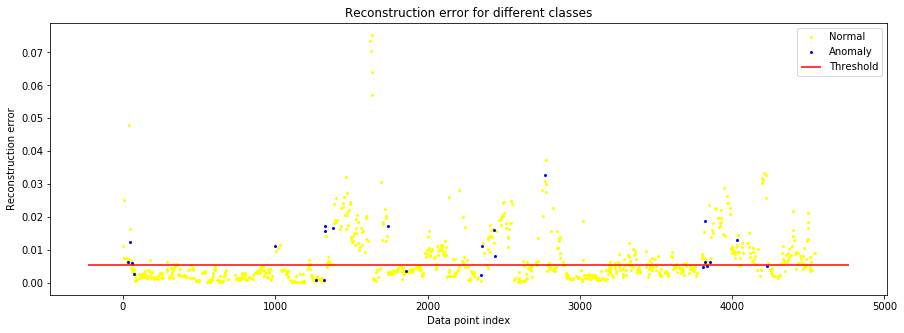

In [48]:
groups = error_df.groupby('true_class')

fig, ax = plt.subplots(figsize=(15, 5))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=2, linestyle='',
            label= "Anomaly" if name == 1 else "Normal", color= 'blue' if name == 1 else 'yellow')

ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="red", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

plt.show()

In [49]:
fig = line_plot(error_df, 'reconstruction_error')
pyo.iplot(fig, image='png')

Model Interpretability


In [50]:
# change X_tes_scaled to pandas dataframe
data_n = pd.DataFrame(X_test_scaled, index= y_test.index, columns=numerical_cols)

In [51]:
def compute_error_per_dim(point):
    
    initial_pt = np.array(data_n.loc[point,:]).reshape(1,9)
    reconstrcuted_pt = autoencoder.predict(initial_pt)
    
    return abs(np.array(initial_pt  - reconstrcuted_pt)[0])

In [53]:
outliers = error_df.index[error_df.reconstruction_error > 0.02].tolist()

In [54]:
outliers

[1719,
 3889,
 1724,
 1538,
 4497,
 2496,
 3930,
 2499,
 3964,
 1595,
 4201,
 2231,
 4401,
 3945,
 1473,
 1624,
 1453,
 1490,
 4193,
 2551,
 1636,
 3985,
 6,
 1695,
 2552,
 2497,
 2209,
 1725,
 1387,
 2773,
 3893,
 3846,
 2758,
 2823,
 1486,
 3987,
 3963,
 4196,
 4225,
 1447,
 2503,
 1398,
 1469,
 1630,
 1459,
 2143,
 1489,
 4220,
 1448,
 4209,
 1638,
 1470,
 1434,
 2779,
 1634,
 2768,
 3976,
 2490,
 2780,
 37,
 2775,
 1463,
 2749]

In [55]:
RE_per_dim = {}
for ind in outliers:
    RE_per_dim[ind] = compute_error_per_dim(ind)
    
RE_per_dim = pd.DataFrame(RE_per_dim, index= numerical_cols).T

In [56]:
RE_per_dim

V_1       V_2       V_3       V_4       V_5       V_6       V_7  \
6     0.014638  0.003515  0.092600  0.265465  0.010913  0.343645  0.109221   
37    0.003270  0.003606  0.180438  0.259043  0.000249  0.543536  0.116841   
1387  0.155145  0.045948  0.093917  0.361689  0.000556  0.013270  0.099666   
1398  0.142550  0.069860  0.197287  0.373950  0.001624  0.040724  0.108918   
1434  0.001368  0.005653  0.009519  0.399590  0.007480  0.140680  0.078999   
1447  0.010512  0.004321  0.000766  0.391596  0.004006  0.126127  0.065835   
1448  0.003821  0.003694  0.003348  0.387718  0.005577  0.165941  0.131773   
1453  0.013906  0.004229  0.009958  0.403884  0.008039  0.205977  0.073408   
1459  0.042055  0.003816  0.001509  0.369903  0.004650  0.110324  0.083435   
1463  0.005913  0.005638  0.016669  0.453273  0.011227  0.118627  0.180011   
1469  0.033851  0.004787  0.002991  0.383292  0.005028  0.149989  0.068335   
1470  0.018790  0.003703  0.001294  0.342427  0.004622  0.198079  0.151103   
1473  0.014290  0.007052  0.012519  0.438258  0.008390  0.113006  0.117293   
1486  0.008797  0.004323  0.038984  0.392428  0.009349  0.091546  0.161364   
1489  0.016756  0.006353  0.015631  0.403871  0.007528  0.177847  0.134582   
1490  0.011164  0.006623  0.034035  0.438891  0.011231  0.091849  0.097132   
1538  0.035326  0.007502  0.032037  0.404331  0.012202  0.092098  0.090502   
1595  0.000572  0.004826  0.026952  0.384850  0.017356  0.062160  0.154041   
1624  0.007948  0.003604  0.374492  0.220549  0.000423  0.399729  0.090260   
1630  0.012753  0.004495  0.421081  0.131323  0.002481  0.335106  0.002481   
1634  0.019809  0.007780  0.453008  0.108872  0.002493  0.340998  0.044134   
1636  0.021283  0.008885  0.414183  0.063068  0.002401  0.299373  0.014732   
1638  0.001977  0.008245  0.430248  0.087966  0.003931  0.307476  0.003230   
1695  0.007592  0.005590  0.182029  0.272523  0.006410  0.267352  0.064356   
1719  0.004600  0.007075  0.119424  0.287816  0.005088  0.211170  0.102298   
1724  0.034984  0.004408  0.114839  0.262257  0.004086  0.254092  0.019306   
1725  0.003851  0.005698  0.113600  0.274444  0.004024  0.161499  0.102728   
2143  0.027406  0.001780  0.206773  0.077142  0.002365  0.382684  0.045679   
2209  0.068865  0.001748  0.145407  0.266007  0.005303  0.112766  0.045084   
2231  0.015408  0.001727  0.112422  0.252093  0.004387  0.184278  0.029166   
2490  0.023492  0.005266  0.091190  0.377099  0.003836  0.050320  0.156449   
2496  0.043583  0.006172  0.100870  0.380194  0.004821  0.071353  0.135420   
2497  0.014762  0.006374  0.082019  0.426426  0.002740  0.054080  0.127901   
2499  0.015550  0.006459  0.082593  0.426242  0.002811  0.074012  0.125937   
2503  0.043490  0.007139  0.086704  0.402097  0.003102  0.033941  0.111986   
2551  0.062991  0.007803  0.081181  0.439731  0.002293  0.046569  0.110987   
2552  0.029416  0.007467  0.082028  0.433809  0.002253  0.039047  0.106593   
2749  0.003726  0.004275  0.068759  0.364520  0.003083  0.174142  0.091964   
2758  0.006289  0.004536  0.015147  0.327564  0.003040  0.230888  0.099439   
2768  0.049720  0.005022  0.074203  0.314917  0.005242  0.416900  0.024717   
2773  0.000797  0.005667  0.089567  0.373844  0.011357  0.318950  0.027575   
2775  0.022756  0.006074  0.085449  0.386464  0.009303  0.168692  0.000320   
2779  0.016910  0.005339  0.102745  0.360812  0.006278  0.276062  0.021533   
2780  0.015282  0.006842  0.118999  0.429982  0.013063  0.120396  0.002163   
2823  0.041487  0.001947  0.300520  0.033798  0.004821  0.171085  0.046910   
3846  0.035342  0.007739  0.118299  0.058220  0.003085  0.337935  0.017068   
3889  0.033804  0.014350  0.102415  0.295521  0.004643  0.136450  0.181619   
3893  0.046193  0.010821  0.097873  0.297247  0.004846  0.120282  0.203421   
3930  0.041219  0.002167  0.133698  0.354226  0.002228  0.059681  0.129031   
3945  0.026085  0.002493  0.175631  0.409017  0.000676  0.065441  0.128369   
3963  0.019826  0.002367  0.15582

In [57]:
def bar_plot(df, data_pt):
    x = df.columns.tolist()
    y = df.loc[data_pt]
    
    trace = {'type': 'bar',
             'x'   : x,
             'y'   : y}
    data = Data([trace])
    layout = {'title' : "<b>Reconstruction error in each dimension for data poitn {}".format(data_pt),
              'titlefont':{'size' : 20},
              'xaxis' : {'title': '<b>Features',
                         'titlefont':{'size' : 20},
                         'tickangle': -45, 'tickfont': {'size':15} },
              'yaxis' : {'title': '<b>Reconstruction Error',
                         'titlefont':{'size' : 20},
                         'tickfont': {'size':15}},
              'margin' : {'l':100, 'r' : 1, 'b': 200, 't': 100, 'pad' : 1},
              'height' : 600, 'width' : 800,
             }
    
    fig = Figure(data = data, layout = layout)
    
    return pyo.iplot(fig, image='png')

In [58]:
for pt in outliers[:3]:
    bar_plot(RE_per_dim, pt)